In [ ]:
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER

# Data Loading

In [2]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

data = reader.read_parquet("preprocessed.parquet/data_clean_symb_1.parquet")
latent_X_train = reader.read_parquet("preprocessed.parquet/latent_X_train.parquet")
latent_X_val = reader.read_parquet("preprocessed.parquet/latent_X_val.parquet")

data = data.sort(['date_id','time_id'])
latent_X_train = latent_X_train.sort(['date_id','time_id'])
latent_X_val = latent_X_val.sort(['date_id','time_id'])

In [3]:
# we pick responder_6 as the target (same target as the data challenge)
target = "responder_6"
features = [col for col in data.columns if "feature" in col]
X, y = data[features], data[target]

n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
X_val = X.slice(n_train)

y_train = y.slice(0, n_train)
y_val = y.slice(n_train)

features = [col for col in latent_X_train.columns if "latent" in col]
latent_X_train = latent_X_train.select(features)
latent_X_val = latent_X_val.select(features)

In [4]:
print(f"X_train shape : {X_train.shape}")
print(f"X_val shape : {X_val.shape}")

print(f"latent_X_train shape : {latent_X_train.shape}")
print(f"latent_X_val shape : {latent_X_val.shape}")

print(f"y_train shape : {y_train.shape}")
print(f"y_val shape : {y_val.shape}")

X_train shape : (1189975, 72)
X_val shape : (297494, 72)
latent_X_train shape : (1189975, 16)
latent_X_val shape : (297494, 16)
y_train shape : (1189975,)
y_val shape : (297494,)


# Models

In [6]:
import lightgbm as lgb
from sklearn.metrics import r2_score

def evaluate_lgbm_fast(X_train_df, y_train_df, X_val_df, y_val_df, label="Model"):
    """
    Optimized LightGBM training for speed.
    """
    # 1. Convert to NumPy for maximum speed
    X_tr, y_tr = X_train_df.to_numpy(), y_train_df.to_numpy().flatten()
    X_va, y_va = X_val_df.to_numpy(), y_val_df.to_numpy().flatten()

    # 2. Use LightGBM Dataset
    train_ds = lgb.Dataset(X_tr, label=y_tr)
    val_ds = lgb.Dataset(X_va, label=y_va, reference=train_ds)

    # 3. Fast Parameters
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": 0.1,   
        "num_leaves": 31,
        "max_bin": 63,           
        "n_jobs": 1,           
        "random_state": 42,
    }

    # 4. Train with Early Stopping
    # We use callback to stop if validation loss doesn't improve for 10 rounds
    model = lgb.train(
        params,
        train_ds,
        num_boost_round=500,     
        valid_sets=[val_ds],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=0) 
        ]
    )

    # 5. Evaluation
    y_pred = model.predict(X_va)
    r2 = r2_score(y_va, y_pred)
    
    print(f"[{label}] Faster Training Completed. R2: {r2:.5f} (Best Iter: {model.best_iteration})")
    return r2, model

# --- Fast Execution ---
print("Training Raw Features Model...")
r2_raw, model_raw = evaluate_lgbm_fast(X_train, y_train, X_val, y_val, label="Raw")

print("\nTraining Latent Features Model...")
latent_cols = [c for c in latent_X_train.columns if "latent" in c]
r2_latent, model_latent = evaluate_lgbm_fast(
    latent_X_train.select(latent_cols), y_train, 
    latent_X_val.select(latent_cols), y_val, 
    label="Latent"
)

Training Raw Features Model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.937934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4536
[LightGBM] [Info] Number of data points in the train set: 1189975, number of used features: 72
[LightGBM] [Info] Start training from score -0.008055
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 0.302053
[Raw] Faster Training Completed. R2: 0.82567 (Best Iter: 84)

Training Latent Features Model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 1189975, number of used features: 16
[LightGBM] [Info] Start training from score -0.008055
Training until validation scores don't improve for 10 rou

# Interpretability

/home/onyxia/work/Advanced-ML/viz_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3427/2295365881.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', ax=ax1, palette='viridis')


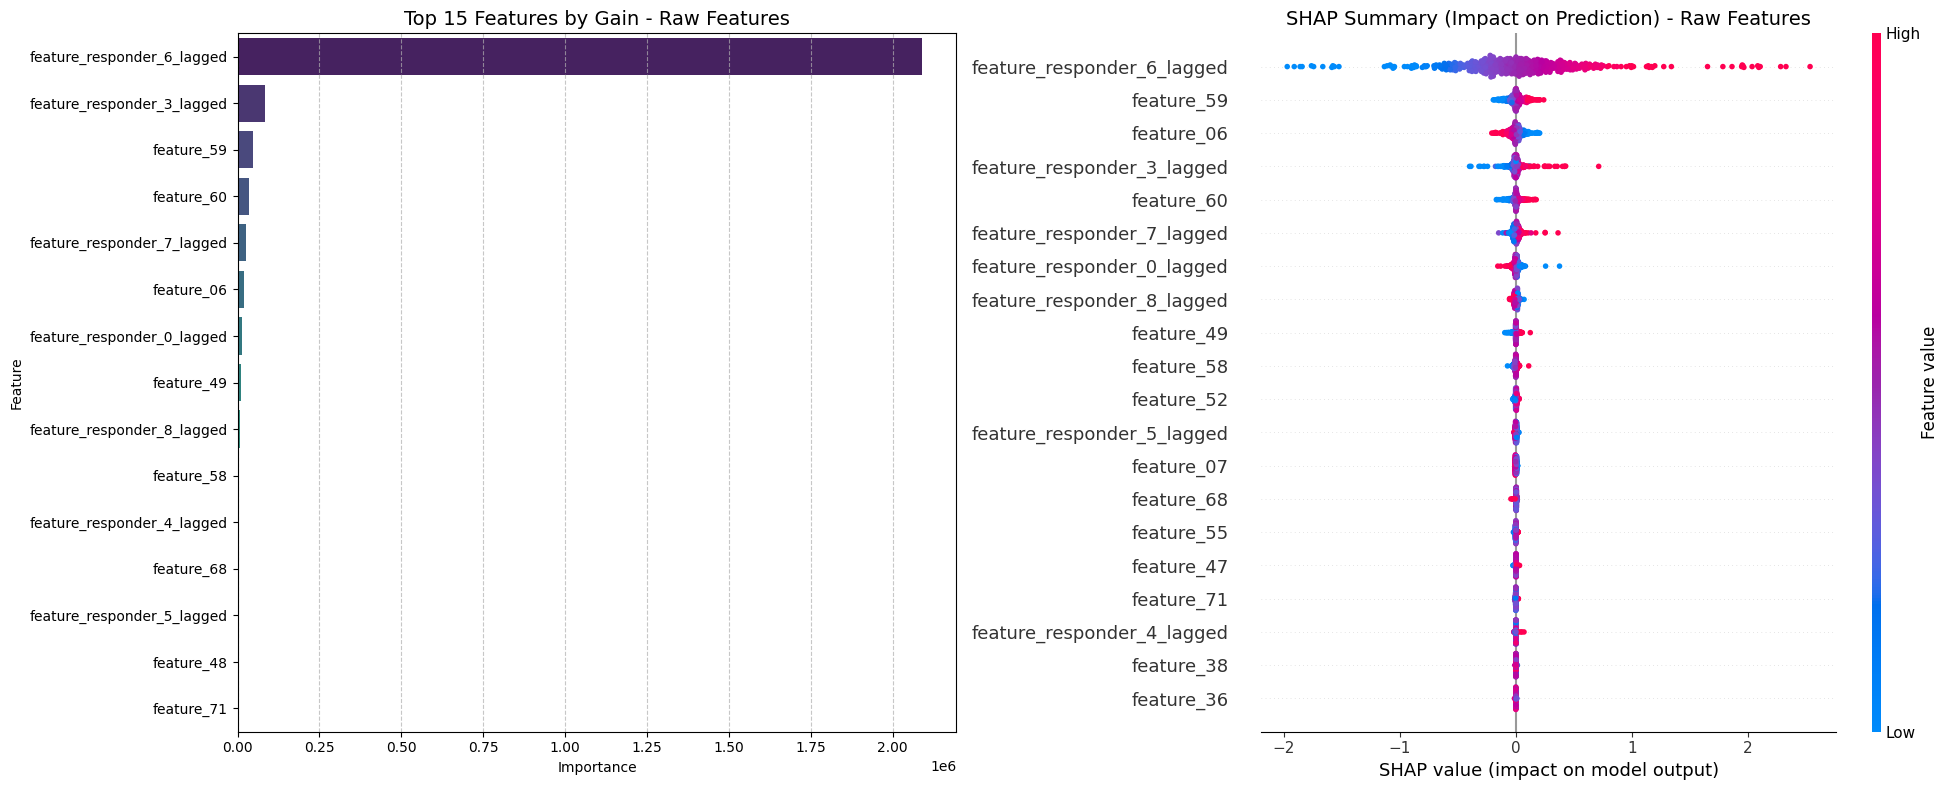

/tmp/ipykernel_3427/2295365881.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', ax=ax1, palette='viridis')


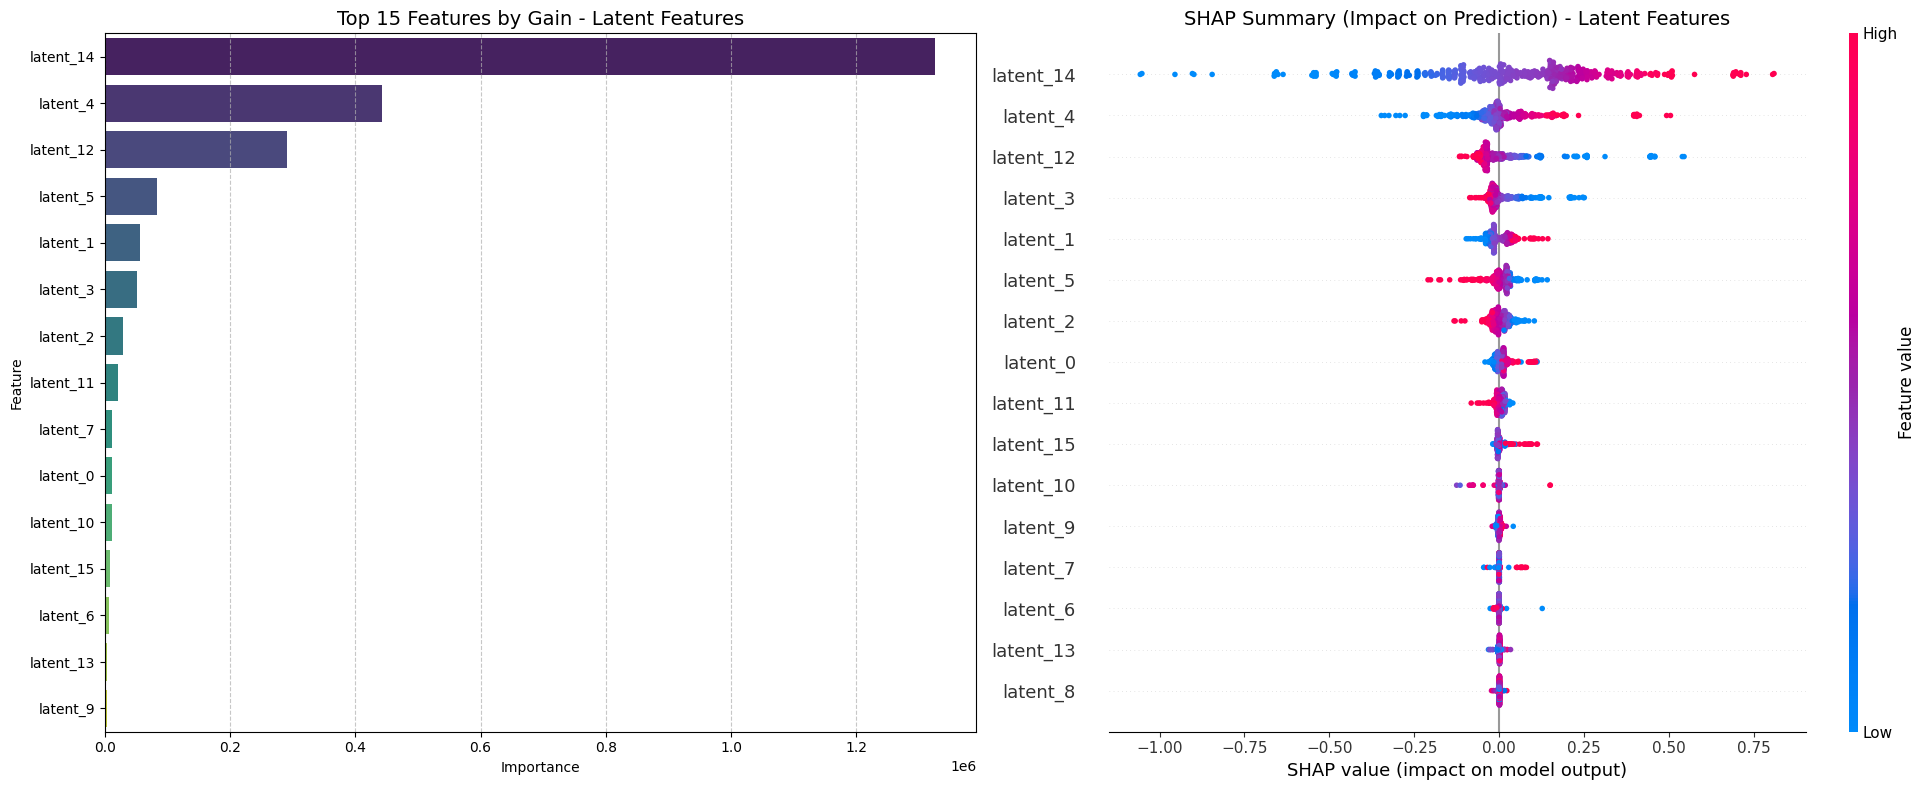

In [ ]:
import seaborn as sns
import shap

def plot_importance_and_shap(model, X_df, title_suffix="Model"):
    # 1. Feature Importance (Gain-based)
    importance_df = pd.DataFrame({
        'Feature': X_df.columns,
        'Importance': model.feature_importance(importance_type='gain')
    }).sort_values(by='Importance', ascending=False).head(15)

    # 2. SHAP Values
    # Use a subset for SHAP calculation to speed up computation
    X_sample = X_df.to_numpy()
    if X_sample.shape[0] > 500:
        # Subsample 500 points for the SHAP explainer
        indices = np.random.choice(X_sample.shape[0], 500, replace=False)
        X_sample_subset = X_sample[indices]
    else:
        X_sample_subset = X_sample

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample_subset)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Left Plot: Bar Chart Importance
    sns.barplot(data=importance_df, x='Importance', y='Feature', ax=ax1, palette='viridis')
    ax1.set_title(f'Top 15 Features by Gain - {title_suffix}', fontsize=14)
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Right Plot: SHAP Summary
    plt.sca(ax2)
    shap.summary_plot(shap_values, X_sample_subset, feature_names=X_df.columns, show=False, plot_size=None)
    ax2.set_title(f'SHAP Summary (Impact on Prediction) - {title_suffix}', fontsize=14)

    plt.tight_layout()
    plt.show()

# --- Execution ---
# Raw Features Analysis
plot_importance_and_shap(model_raw, X_val, title_suffix="Raw Features")

# Latent Features Analysis
latent_cols = [col for col in latent_X_val.columns if "latent" in col]
plot_importance_and_shap(model_latent, latent_X_val.select(latent_cols), title_suffix="Latent Features")